In [1]:
from cmdstanpy import model
import numpy as np
import scanpy as sc
import json
import pandas as pd

In [2]:
#from cmdstanpy import cmdstan_path, set_cmdstan_path
#set_cmdstan_path('/Users/alexander/cmdstan')

In [2]:
#only run this is necessary, takes a while
adata=sc.read_h5ad("N_ribas310_clones.h5")

In [3]:
sc.pp.filter_cells(adata,min_counts=1000)

In [4]:
sc.pp.highly_variable_genes(adata,n_top_genes=5000,subset=True)

In [5]:
adata

AnnData object with n_obs × n_vars = 19443 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'patient', 'ScrubDoublet', 'ScrubDoublet_score', 'RNA_snn_res.0.8', 'seurat_clusters', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_iced_main', 'celltype_iced_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'celltype_mid_main', 'celltype_mid_fine', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'n_counts', 'treatment', 'Myeloid', 'NK', 'Macrophage', 'Monocyte', 'B Cells', 'HSCs', 'T cells', 'T_regs', 'prolif', 'endothelial', 'fibroblast', 'erythroid', 'Th17', 'Th22', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'Diffusion component 0', 'Diffusion component 1', 'Diffusion component 2', 'Diffusion component 3'

In [5]:
X = np.asarray(adata.layers['counts'])

In [2]:
cellsxlatent=np.zeros((100,10))
latentxgenes=np.zeros((10,80))

for i in range(cellsxlatent.shape[0]):
    for j in range(cellsxlatent.shape[1]):
        cellsxlatent[i][j]=int(abs(np.random.normal(2,5)))

for i in range(latentxgenes.shape[0]):
    for j in range(latentxgenes.shape[1]):
        latentxgenes[i][j]=int(abs(np.random.normal(2,5)))

In [3]:
simul=np.matmul(np.asarray(cellsxlatent),np.asarray(latentxgenes))

TODO:
-prior predictive checks (plot data drawn from priors)
-simulated data (for matrix factorization, randomly generate cellsxfactors, factorsxgenes matrices



In [21]:
#X = list(X)
new_X = []
for i in range(150):

    curr = []
    for j in range(150):

        curr.append(int(X[i][j]))
    new_X.append(curr)

In [22]:
X=new_X

In [35]:
X=prior_pred.astype(int).tolist()

In [23]:
X = X.astype(int).tolist()

AttributeError: 'list' object has no attribute 'astype'

In [4]:
X=simul.astype(int).tolist()

In [24]:
#This takes quite a while... only run it once run below to change the hyperparams
data = {}
data['C'] = len(X)
data['G'] = len(X[0])

#hyperparameters, just holder values
data['a_prime'] = 1
data['b_prime'] = float(np.mean(np.sum(adata.layers['counts'],axis=1))/np.std(np.sum(adata.layers['counts'],axis=1)))
#data['b_prime'] = float(np.mean(np.sum(simul,axis=1))/np.std(np.sum(simul,axis=1)))
data['a'] = .3

data['c_prime'] = 1
data['d_prime'] = float(np.mean(np.sum(adata.layers['counts'],axis=0))/np.std(np.sum(adata.layers['counts'],axis=0)))
#data['d_prime'] = float(np.mean(np.sum(simul,axis=0))/np.std(np.sum(simul,axis=0)))
data['c'] = .3

data['k'] = 10

data['X'] = X

scHPF_data = ('scHPF.data.json')
print(scHPF_data)
with open(scHPF_data, "w") as outfile:
    json.dump(data, outfile)


scHPF.data.json


In [19]:
import os
from cmdstanpy import cmdstan_path, CmdStanModel

scHPF_stan = 'scHPF.stan'
scHPF_model = CmdStanModel(stan_file=scHPF_stan)
scHPF_model.name
scHPF_model.stan_file
scHPF_model.exe_file
scHPF_model.code()

INFO:cmdstanpy:compiling stan program, exe file: /home/lf2684/notebooks/pp_project/scHPF
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/lf2684/notebooks/pp_project/scHPF


"data {\nint<lower=0> C;\nint<lower=0> G;\n\nreal<lower=0> a_prime;\nreal<lower=0> b_prime;\nreal<lower=0> a;\n\nreal<lower=0> c_prime;\nreal<lower=0> d_prime;\nreal<lower=0> c;\n\nint<lower=0> k;\n\nmatrix<lower=0> [C,G] X;\n\n\n\n}\n\nparameters {\nmatrix<lower=0> [k,C] theta;\nmatrix<lower=0> [k,G] beta;\nvector<lower=0>[G] eta;\nvector<lower=0>[C] xi;\n\n}\nmodel {\n\nxi ~ gamma(a_prime,b_prime);\n\nfor (kk in 1:k){\ntheta[kk] ~ gamma(a,xi);\n}\n\neta ~ gamma(c_prime,d_prime);\n\nfor (kk in 1:k){\nbeta[kk] ~ gamma(c,eta);\n}\n\nprint(dims(theta'*beta));\n\n}\n"

In [25]:
scHPF_fit = scHPF_model.variational(data=scHPF_data, output_dir='.',show_console=True,tol_rel_obj=0.001)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


RuntimeError: The algorithm may not have converged.
If you would like to inspect the output, re-call with require_converged=False

In [50]:
#print(scHPF_fit.column_names)
print(scHPF_fit.variational_params_dict)

OrderedDict([('lp__', 0.0), ('log_p__', 0.0), ('log_g__', 0.0), ('theta[1,1]', 4.68669), ('theta[2,1]', 1.42585), ('theta[3,1]', 3.65885), ('theta[4,1]', 0.716941), ('theta[5,1]', 2.80488), ('theta[6,1]', 4.33798), ('theta[7,1]', 2.29555), ('theta[8,1]', 1.09941), ('theta[9,1]', 0.707504), ('theta[10,1]', 2.8275), ('theta[11,1]', 1.18492), ('theta[12,1]', 1.41127), ('theta[13,1]', 2.52119), ('theta[14,1]', 3.86119), ('theta[15,1]', 3.94077), ('theta[16,1]', 0.680117), ('theta[17,1]', 4.21996), ('theta[18,1]', 1.91106), ('theta[19,1]', 4.77332), ('theta[20,1]', 1.55488), ('theta[21,1]', 2.6118), ('theta[22,1]', 1.59794), ('theta[23,1]', 3.17644), ('theta[24,1]', 2.82174), ('theta[25,1]', 1.28019), ('theta[26,1]', 1.43855), ('theta[27,1]', 1.99782), ('theta[28,1]', 3.21102), ('theta[29,1]', 3.68963), ('theta[30,1]', 1.94142), ('theta[31,1]', 2.79088), ('theta[32,1]', 3.72993), ('theta[33,1]', 2.90643), ('theta[34,1]', 2.89447), ('theta[35,1]', 5.47778), ('theta[36,1]', 1.19268), ('theta[

In [5]:
#prior predictive check
xi=[]
theta=[]
a_prime=1
a=.3
c=.3
b_prime=float(np.mean(np.sum(adata.layers['counts'],axis=1))/np.std(np.sum(adata.layers['counts'],axis=1)))
c_prime=1
d_prime=float(np.mean(np.sum(adata.layers['counts'],axis=0))/np.std(np.sum(adata.layers['counts'],axis=0)))
prior_pred=np.zeros((len(X),len(X[0]))).tolist()
for cc in range(len(X)):
    xi_ent=np.random.gamma(a_prime,b_prime)
    xi.append(xi_ent)
    theta_ent=[]
    for kk in range(10):
        theta_ent.append(np.random.gamma(a,xi_ent))
    theta.append(theta_ent)
eta=[]
beta=[]
for g in range(len(X[0])):
    eta_ent=np.random.gamma(c_prime,d_prime)
    eta.append(eta_ent)
    beta_ent=[]
    for kk in range(10):
        beta_ent.append(np.random.gamma(c,eta_ent))
    beta.append(beta_ent)
for c in range(len(X)):
    if c%100==0:
        print(c)
    for g in range(len(X[0])):
        prior_pred[c][g]=np.random.poisson(np.dot(theta[c],beta[g]))
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [9]:
prior_pred=np.asarray(prior_pred)

In [12]:
adata_prior=sc.AnnData(prior_pred)

In [40]:
adata_prior.write_h5ad("prior_predictive.h5")

In [20]:
max(prior_pred.flatten())

157

In [19]:
max(X.flatten())

2201.0

In [21]:
min(prior_pred.flatten())

0

In [22]:
min(X.flatten())

0.0

In [23]:
np.mean(X.flatten())

0.32021102

In [24]:
np.mean(prior_pred.flatten())

0.1892347638445035

In [13]:
sc.pp.neighbors(adata_prior)

         Falling back to preprocessing with `sc.pp.pca` and default params.


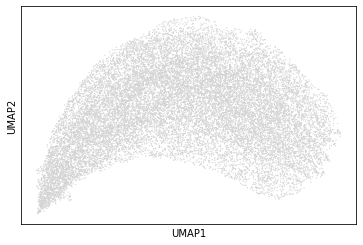

In [14]:
sc.tl.umap(adata_prior)
sc.pl.umap(adata_prior)

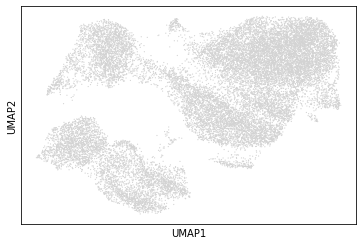

In [15]:
sc.pl.umap(adata)

In [97]:
def change_hyperparams():
    #TODO write func that just changes the hyperparams of saved .json
    scHPF_data = os.path.join(cmdstan_path(), 'scHPF','scHPF.data.json')
    

In [34]:
pd.DataFrame(scHPF_fit.stan_variables()["theta"])

,0,1,2,3,4,5,6,7,8,9
0,0.029708,0.003764,0.301000,0.136296,0.011049,0.016403,0.021444,0.039525,0.021525,0.676308
1,0.003770,0.041527,0.010302,0.005366,0.275789,0.050557,0.005731,0.005718,0.063147,0.005412
2,0.040495,0.038149,0.009284,0.100616,0.048679,0.192456,0.008817,0.012078,0.586982,0.034136
3,0.028220,0.040134,0.032400,2.084780,0.032449,0.022400,0.013977,0.693180,0.376447,0.288423
4,0.011839,0.835521,0.013385,0.060266,0.015993,0.017650,1.926850,0.070135,0.014498,0.099656
...,...,...,...,...,...,...,...,...,...,...
1495,0.006913,0.005683,0.008962,0.173181,0.003234,0.084524,0.008705,0.003705,0.012448,0.010781
1496,0.022260,0.063524,0.009440,0.013071,0.091713,0.034647,0.065224,0.007347,0.190355,0.295064
1497,0.093493,0.012938,0.104822,0.025738,0.013363,0.010867,0.009970,0.109850,0.032334,0.007226
1498,0.536909,0.610709,0.008259,0.007504,0.018561,0.008668,0.006958,0.093617,0.006578,0.007034


In [13]:
pd.DataFrame(scHPF_fit.stan_variables()["theta"])

,0,1,2,3,4,5,6,7,8,9
0,6.641970,0.03888,2.043500,0.230456,0.541804,1.008450,2.842070,0.613297,3.641750,0.680769
1,3.282430,7.17612,5.054520,5.891600,0.171051,6.822490,4.051620,9.016870,4.433180,4.755950
2,0.038568,3.32784,4.105120,7.087280,4.170710,1.843210,0.046017,3.190160,4.016170,0.083305
3,0.267856,1.12684,0.452402,2.790350,3.660360,5.617510,1.322120,0.585008,4.319370,5.873580
4,6.086000,5.41267,0.410353,4.593910,7.806130,5.165260,0.705507,10.982900,5.970640,0.325174
...,...,...,...,...,...,...,...,...,...,...
95,5.982120,4.57345,4.121910,1.620210,4.795150,3.605310,0.049534,0.100403,5.829470,1.119110
96,0.051542,8.47598,2.974340,5.601910,0.026976,0.570184,0.066425,3.797680,3.330860,4.549220
97,4.110460,7.45384,3.163650,1.617310,1.818220,8.409730,1.513040,1.993480,2.499390,6.903970
98,2.898320,5.60566,2.755400,3.799640,4.479650,4.678010,2.844930,0.785194,0.872369,7.624800


In [14]:
pd.DataFrame(cellsxlatent)

,0,1,2,3,4,5,6,7,8,9
0,4.0,1.0,7.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0
1,5.0,8.0,3.0,1.0,8.0,9.0,6.0,6.0,4.0,2.0
2,0.0,5.0,0.0,7.0,3.0,6.0,4.0,1.0,0.0,4.0
3,0.0,1.0,2.0,5.0,2.0,3.0,3.0,7.0,4.0,2.0
4,5.0,0.0,5.0,8.0,7.0,7.0,9.0,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
95,0.0,4.0,9.0,7.0,5.0,1.0,2.0,3.0,2.0,4.0
96,0.0,6.0,1.0,2.0,9.0,8.0,1.0,0.0,2.0,2.0
97,2.0,5.0,5.0,1.0,8.0,1.0,3.0,8.0,4.0,6.0
98,4.0,3.0,1.0,5.0,6.0,0.0,2.0,6.0,4.0,6.0


In [15]:
pd.DataFrame(scHPF_fit.stan_variables()["beta"])

,0,1,2,3,4,5,6,7,8,9
0,0.946809,3.712940,7.402950,3.582110,2.975220,9.04573,1.796570,3.323830,5.74294,2.582800
1,8.992820,2.042410,8.870730,3.836380,5.523610,5.39646,2.762210,3.261040,6.88774,11.490100
2,1.662730,7.945660,5.460260,2.954550,0.725557,8.87769,0.371448,2.730500,4.20705,1.132690
3,3.963390,1.686270,3.850680,0.010306,3.972500,1.26145,9.202500,1.908620,5.73743,0.185611
4,1.252930,7.490140,4.533110,1.512520,10.411400,2.05128,0.055242,0.645222,4.01980,0.493333
...,...,...,...,...,...,...,...,...,...,...
75,1.711670,0.689719,0.890475,1.474890,4.356000,1.34950,5.576630,3.469460,2.17962,3.523630
76,3.880900,4.609090,1.409490,8.047260,0.208637,7.07121,1.868320,3.736520,3.44276,3.906590
77,0.073725,0.018596,1.057210,6.340990,0.841803,6.27430,4.193430,4.315660,7.13325,6.551490
78,5.906500,0.877526,4.971510,4.580830,0.304740,2.51019,0.139189,0.206927,5.71612,1.648960


In [16]:
pd.DataFrame(latentxgenes.T)

,0,1,2,3,4,5,6,7,8,9
0,2.0,7.0,2.0,3.0,2.0,5.0,7.0,6.0,3.0,4.0
1,8.0,6.0,6.0,7.0,5.0,3.0,1.0,6.0,12.0,4.0
2,1.0,6.0,3.0,1.0,6.0,3.0,5.0,5.0,0.0,6.0
3,5.0,3.0,5.0,2.0,0.0,0.0,8.0,0.0,6.0,0.0
4,0.0,4.0,2.0,9.0,6.0,0.0,7.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
75,5.0,0.0,0.0,3.0,2.0,3.0,4.0,2.0,5.0,0.0
76,5.0,3.0,2.0,2.0,5.0,8.0,1.0,7.0,1.0,4.0
77,2.0,1.0,0.0,3.0,0.0,10.0,3.0,8.0,7.0,3.0
78,3.0,5.0,6.0,4.0,0.0,3.0,0.0,2.0,1.0,3.0


In [17]:
pd.DataFrame(np.matmul(scHPF_fit.stan_variables()["theta"],scHPF_fit.stan_variables()["beta"].T))

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,62.937751,130.011589,51.359896,86.031289,41.462340,84.189191,89.384024,67.705291,91.030148,95.626640,...,109.987484,75.715844,103.738058,38.657400,71.539022,45.589653,60.733507,55.897905,75.638119,66.108823
1,225.491089,275.153425,218.338040,134.732845,131.670842,168.602686,286.658127,112.995845,201.185684,259.725478,...,187.402429,250.178370,195.802571,255.631324,218.570071,114.009289,223.732004,204.713521,130.592527,196.778630
2,131.217966,142.882607,114.968705,70.108542,119.752995,69.431118,112.481135,61.481234,99.405294,114.199852,...,130.734292,149.248752,78.508185,140.317702,167.312818,57.496793,118.369411,107.575572,85.680940,125.473218
3,123.782716,172.759725,99.552847,65.515228,85.390732,81.085862,134.609110,97.692737,78.096346,126.253877,...,105.516589,105.527533,98.425245,108.952875,167.481295,68.792898,112.284097,133.900573,67.499053,96.812437
4,188.203086,240.666378,176.197520,134.172564,180.130261,174.224514,235.098092,130.240477,200.397398,207.494034,...,176.425083,195.523896,163.037170,250.887236,283.306803,118.463990,188.448443,164.170123,116.161287,141.315377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,142.633668,205.334330,135.150426,105.208412,144.259271,110.724064,141.057200,112.695124,140.019836,134.758770,...,171.743640,152.520781,133.047835,138.263353,197.654615,62.480873,114.546917,91.370832,112.967012,140.514248
96,122.463977,156.657492,134.866427,54.649022,105.045015,69.202856,168.365215,59.766590,127.326572,147.551540,...,115.528623,139.998011,103.963862,198.401909,144.426095,54.568115,136.129931,112.659862,76.966341,119.812891
97,183.792649,249.105441,188.431566,92.240823,128.771563,128.088143,235.333692,125.969920,169.550197,199.694007,...,153.376134,174.358352,161.015184,198.712934,196.653345,81.777128,173.479366,146.345470,101.914502,158.024071
98,145.634675,230.558140,135.918733,89.385147,128.023569,99.265935,206.055005,114.456699,160.405858,185.479431,...,139.635910,126.135490,143.114890,158.716894,186.562644,90.069021,146.598750,131.941931,84.367882,119.076028


In [18]:
pd.DataFrame(simul)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,63.0,137.0,51.0,86.0,38.0,82.0,95.0,70.0,92.0,99.0,...,106.0,78.0,112.0,38.0,72.0,47.0,62.0,57.0,74.0,66.0
1,234.0,278.0,210.0,138.0,147.0,173.0,287.0,108.0,185.0,274.0,...,197.0,238.0,182.0,269.0,227.0,127.0,229.0,211.0,126.0,176.0
2,142.0,138.0,122.0,61.0,130.0,75.0,111.0,57.0,92.0,116.0,...,134.0,159.0,63.0,152.0,177.0,63.0,119.0,118.0,85.0,127.0
3,128.0,173.0,100.0,71.0,97.0,84.0,137.0,100.0,74.0,135.0,...,123.0,98.0,92.0,120.0,171.0,74.0,115.0,145.0,70.0,89.0
4,195.0,239.0,174.0,144.0,192.0,187.0,239.0,127.0,187.0,222.0,...,186.0,184.0,154.0,264.0,289.0,133.0,192.0,179.0,116.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,136.0,215.0,140.0,99.0,146.0,102.0,144.0,128.0,147.0,134.0,...,194.0,147.0,138.0,133.0,195.0,58.0,118.0,91.0,125.0,154.0
96,129.0,158.0,136.0,47.0,107.0,69.0,173.0,56.0,118.0,157.0,...,121.0,141.0,93.0,208.0,145.0,62.0,144.0,115.0,76.0,118.0
97,178.0,249.0,190.0,100.0,120.0,124.0,237.0,130.0,177.0,196.0,...,153.0,178.0,173.0,189.0,192.0,80.0,172.0,141.0,106.0,171.0
98,144.0,231.0,142.0,84.0,119.0,97.0,207.0,118.0,175.0,179.0,...,135.0,135.0,148.0,156.0,184.0,87.0,143.0,126.0,87.0,128.0


In [100]:
help(scHPF_model.variational)

Help on method variational in module cmdstanpy.model:

variational(data: Union[Mapping[str, Any], str, NoneType] = None, seed: Union[int, NoneType] = None, inits: Union[float, NoneType] = None, output_dir: Union[str, NoneType] = None, sig_figs: Union[int, NoneType] = None, save_diagnostics: bool = False, save_profile: bool = False, algorithm: Union[str, NoneType] = None, iter: Union[int, NoneType] = None, grad_samples: Union[int, NoneType] = None, elbo_samples: Union[int, NoneType] = None, eta: Union[float, NoneType] = None, adapt_engaged: bool = True, adapt_iter: Union[int, NoneType] = None, tol_rel_obj: Union[float, NoneType] = None, eval_elbo: Union[int, NoneType] = None, output_samples: Union[int, NoneType] = None, require_converged: bool = True, refresh: Union[int, NoneType] = None) -> cmdstanpy.stanfit.CmdStanVB method of cmdstanpy.model.CmdStanModel instance
    Run CmdStan's variational inference algorithm to approximate
    the posterior distribution of the model conditioned o